## Midterm experiment redo

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import pandas as pd

In [2]:

def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(loc=0.0, scale=1.0, size=M))
    
    return S

def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0) 


def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), norm.cdf(d1)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1), -norm.cdf(-d1)
    

    
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def binomial_option_pricing(S, K, T, r, sigma, N, monitoring_dates, option_type='call'):
    dt = T / N  # Length of each time interval
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    q = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize arrays to store stock prices and option values
    stock_prices = np.zeros((N+1, N+1))
    option_values = np.zeros((N+1, N+1))

    # Initialize stock prices at maturity
    for i in range(N+1):
        for j in range(i+1):
            stock_prices[i, j] = S * (u**j) * (d**(i-j))

    # Calculate payoff at maturity
    if option_type == 'call':
        option_values[N, :] = np.maximum(stock_prices[N, :] - K, 0)
    else:  # put
        option_values[N, :] = np.maximum(K - stock_prices[N, :], 0)

    # Backward recursion for option price
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            if i*dt in monitoring_dates:
                continuation_value = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
                if option_type == 'call':
                    option_values[i, j] = np.maximum(stock_prices[i, j] - K, continuation_value)
                else:
                    option_values[i, j] = np.maximum(K - stock_prices[i, j], continuation_value)
            else:
                option_values[i, j] = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
    delta = (option_values[1, 1] - option_values[1, 0])/(stock_prices[1, 1] - stock_prices[1, 0])

    return option_values[0,0], delta#, stock_prices

def calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 10000, option_type='put'):
    hedge_error = np.zeros(M)
    for m in tqdm(range(M)):
        V0, delta = binomial_option_pricing(S0, K, T, mu, sigma, 100, monitoring_dates, option_type=option_type)
        #print(f'Price of the option: {V0}', f'Delta: {delta}')
        cash_flow = V0 - delta * S0
        No_of_shares = delta
        updated_monitoring_dates = monitoring_dates
        #print(f'Initial cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
        S = stock_price_simulator(S0, mu, sigma, T, hedge_freq, 1).flatten()
        #print(S)
        dt = T/hedge_freq
        #print("time stpes in hedging dates", dt)
        for i in range(1, len(hedging_dates)- 1):
            #print(f'Hedging date: {i*dt}')
            updated_monitoring_dates = updated_monitoring_dates - dt
            updated_monitoring_dates = updated_monitoring_dates[updated_monitoring_dates > 0]    
            #print(f'Updated monitoring dates: {updated_monitoring_dates}')
            V1, delta2 = binomial_option_pricing(S[i], K, updated_monitoring_dates[-1], mu, sigma, 100, updated_monitoring_dates, option_type='put')
            if i*dt in monitoring_dates:
                #print("inside", i*dt)
                #print(f'Price of stock: {S[i]}', f'Price of the option: {V1}', f'K: {K}', f'payoff : {payoff_fun(S[i], K, "put")}')
                if payoff_fun(S[i], K, 'put') > V1:
                    #print("Exercise")
                    break
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print(f'Cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
            else:
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print("Not in monitoring date")
            #print("i", i, No_of_shares)
        if i == len(hedging_dates)-2:
            #print("Last date", i)
            payoff_last = payoff_fun(S[i+1], K, 'put')   
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i+1]
        else:
            #print("i at end", i)
            payoff_last = payoff_fun(S[i], K, 'put')
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i]
        #print(f'Final Hedge Error: {payoff_last - final_cash_flow}')
        hedge_error[m] = payoff_last - final_cash_flow
        
    return hedge_error

    
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model

    
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0
    
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)




def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate2):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
     
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    # Compile the model
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    model2  = create_shallow_NN(1, no_hidden_units)
    model2.compile(loss='mean_squared_error', optimizer=Adam(l_rate2))
    ## Train the model  
    model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[es], verbose = 0)
    
    # Test the model
    y_hat_val = model2.predict(X_test)
    
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    
    ## Get the weights of the model
    w1 = model2.layers[0].get_weights()[0].reshape(-1)
    b1 = model2.layers[0].get_weights()[1].reshape(-1)
    w2 = model2.layers[1].get_weights()[0].reshape(-1)
    b2 = model2.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model2.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    
    ## Calculate the option price at the previous monitoring dates
    
    model2.optimizer.learning_rate.assign(0.01)
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        es2 = EarlyStopping(monitor='val_loss', mode='min', patience=20,restore_best_weights=True, min_delta=0.00001, verbose=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model2.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[es2], verbose =0)
        
        y_hat = model2.predict(X_test)
        
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model2.layers[0].get_weights()[0].reshape(-1)
        b1 = model2.layers[0].get_weights()[1].reshape(-1)
        w2 = model2.layers[1].get_weights()[0].reshape(-1)
        b2 = model2.layers[1].get_weights()[1].reshape(-1)
        weights.append(model2.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        if i == 1:
            option_price[:, i-1] = continuation_value
        
        else:
            option_price[:, i-1] = np.maximum(fun_h, continuation_value)    
        
    return option_price[0,0] , weights, errors


def portfolio_value(weights, stock_price, r, sigma, dt, S0):
    
    weights_layer1 = weights[0].flatten()
    weights_layer2 = weights[2].flatten()
    bias_layer1 = weights[1]
    bias_layer2 = weights[3][0]
    St = stock_price/S0
    
    cost = bias_layer2
    for i in range(len(weights_layer1)):
        wi, bi = weights_layer1[i], bias_layer1[i]
        
        if wi >= 0 and bi >= 0:
            # Forward Price
            temp_cost = wi * St * np.exp(r * dt) + bi
        elif wi > 0 and bi < 0:
            # European Call Option
            strike = -bi / wi
            temp_cost = wi * black_scholes(St, strike, r, sigma, dt, option_type='call')
        elif wi < 0 and bi > 0:
            # European Put Option
            strike = -bi / wi
            temp_cost = -wi * black_scholes(St, strike, r, sigma, dt, option_type='put')
        else:
            # Expected value is 0
            temp_cost = 0.0
            
        cost += temp_cost * weights_layer2[i]
    
    return cost * np.exp(-r * dt)

def check_payoffs(stock_price, weights, S0):
    """
    Given a single stock_price, compute the total 
    payoff implied by the 2-layer NN with piecewise logic.
    
    :param stock_price:  current price of the underlying (float)
    :param weights:      a tuple/list containing 
                         [weights_layer1, bias_layer1, weights_layer2, bias_layer2]
    :param S0:           normalizing constant (e.g. initial stock price)
    :return:             total payoff (float)
    """
    payoffs = 0.0

    # Globally defined T and M
    dt = T/M
    
    # Extract layers
    weights_layer1 = weights[0].flatten()  # array of w1_i
    bias_layer1    = weights[1]  # array of b1_i
    weights_layer2 = weights[2].flatten()  # array of w2_i
    bias_layer2    = weights[3][0]  # float or array of length 1

    # Normalize
    normalized_stock = stock_price / S0
    
    # Start from second-layer bias
    # (if bias_layer2 is an array, do bias_layer2[0])
    payoffs = bias_layer2

    # Loop over all first-layer neurons
    for i in range(len(weights_layer1)):
        w1i = weights_layer1[i]
        b1i = bias_layer1[i]
        w2i = weights_layer2[i]

        # Case 1: w1 >= 0, b1 >= 0 => Forward contract
        if w1i >= 0 and b1i >= 0:
            payoffs += w2i * (w1i * normalized_stock + b1i)

        # Case 2: w1 > 0, b1 < 0 => call-like payoff
        elif w1i > 0 and b1i < 0:
            strike_call = -b1i / w1i
            call_payoff = max(normalized_stock - strike_call, 0)
            payoffs += w2i * w1i * call_payoff

        # Case 3: w1 < 0, b1 > 0 => put-like payoff
        elif w1i < 0 and b1i > 0:
            strike_put = -b1i / w1i
            put_payoff = max(strike_put - normalized_stock, 0)
            payoffs -= w2i * w1i * put_payoff

        else:
            # The "else" might be w1 <= 0, b1 <= 0 => payoff is effectively 0
            0.0

    return payoffs

def cal_continuation_value2(weights, no_hidden_units, stock_prices, r, sigma, dt, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
     ## Get the weights of the model
    w1 = weights[0].reshape(-1)
    b1 = weights[1].reshape(-1)
    w2 = weights[2].reshape(-1)
    b2 = weights[3].reshape(-1)
    normalized_stock_values = stock_prices/normalizer
    continuation_value = 0
    for i in range(no_hidden_units):
        continuation_value += expected_value(w1[i], b1[i], normalized_stock_values, r, sigma, dt) * w2[i]
        #print(continuation_value)
    continuation_value += b2
    
    return continuation_value * np.exp(-r*dt) 

def hedging_simulation_proper_pnl(stock_paths, weights, r, sigma, T, M, S0, K, price, hidden_nodes):
    N = len(stock_paths)
    dt = T / M
    hedging_errors = np.zeros(N, dtype=float)

    for i in range(N):
        cash_account = price
        weights_now = weights[-1]
        
        # Initial portfolio setup
        cash_account -= portfolio_value(weights_now, stock_paths[i][0], r, sigma, dt, S0)
        
        #print("cash account at the start", cash_account)
        
        for j in range(1, M):
            cash_account *= np.exp(r * dt)
            
            Exercise_value = payoff_fun(stock_paths[i][j], K, "put")
            weights_next = weights[-(j+1)]
            cont_value = cal_continuation_value2(weights_next, hidden_nodes, stock_paths[i][j], r, sigma, dt, S0)
            
            if Exercise_value > cont_value:
                # At exercise: get payoff from current portfolio and exercise
                portfolio_t = check_payoffs(stock_paths[i][j], weights_now, S0)
                cash_account += portfolio_t
                hedging_errors[i] = cash_account - Exercise_value
                break
            
            # Rebalancing: get payoff from old portfolio, pay for new one
            portfolio_t = check_payoffs(stock_paths[i][j], weights_now, S0)
            cash_account += portfolio_t
            
            weights_now = weights[-(j+1)]
            cash_account -= portfolio_value(weights_now, stock_paths[i][j], r, sigma, dt, S0)
        else:
            cash_account *= np.exp(r * dt)
            portfolio_t = check_payoffs(stock_paths[i][M], weights_now, S0)
            cash_account += portfolio_t
            payoff_T = payoff_fun(stock_paths[i][M], K, "put")
            hedging_errors[i] = cash_account - payoff_T
            
    return hedging_errors

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error1 = hedging_simulation_proper_pnl(stock_prices, weights3, r, sigma, T, M, S0, 50, price3, nodes)

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error08 = hedging_simulation_proper_pnl(stock_prices, weights2, r, sigma, T, M, S0, 50 * 0.8, price2, nodes)

# stock_prices = stock_price_simulator(S0, r, sigma, T, M, 10000)
# hedge_error12 = hedging_simulation_proper_pnl(stock_prices, weights, r, sigma, T, M, S0, 50 * 1.2, price, nodes)

# plt.hist(hedge_error12,bins=50, edgecolor='black',color='r', alpha=0.7, label='K/S0=1.2')
# plt.hist(hedge_error08, bins=50, edgecolor='k',color='g',  alpha=0.7, label='K/S0 = 0.8')
# plt.hist(hedge_error1, bins=50, edgecolor='k', alpha=0.7, label='K/S0 = 1')
# plt.legend()
# plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


C:\Users\nitai\AppData\Local\Temp\ipykernel_25608\1978258387.py:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  continuation_value[j] += b2


Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 5.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 21.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 101: early stopping
Restoring model weights from the end of the best epoch: 81.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 69.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
Epoch 115: early stopping
Restoring model weights from the end of the best epoch: 95.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 46.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
Epoch 218: early stopping
Restoring model weights fro

100%|██████████| 1000/1000 [24:21<00:00,  1.46s/it]


RLNN mean hedge error (K=0.8): 0.4499197424245267
Binomial mean hedge error (K=0.8): -0.0010542226947053421
RLNN mean hedge error (K=1.0): -0.0010159939012668268
Binomial mean hedge error (K=1.0): -0.01773868865055108
RLNN mean hedge error (K=1.2): -0.006615075026702914
Binomial mean hedge error (K=1.2): -0.026534496953521555


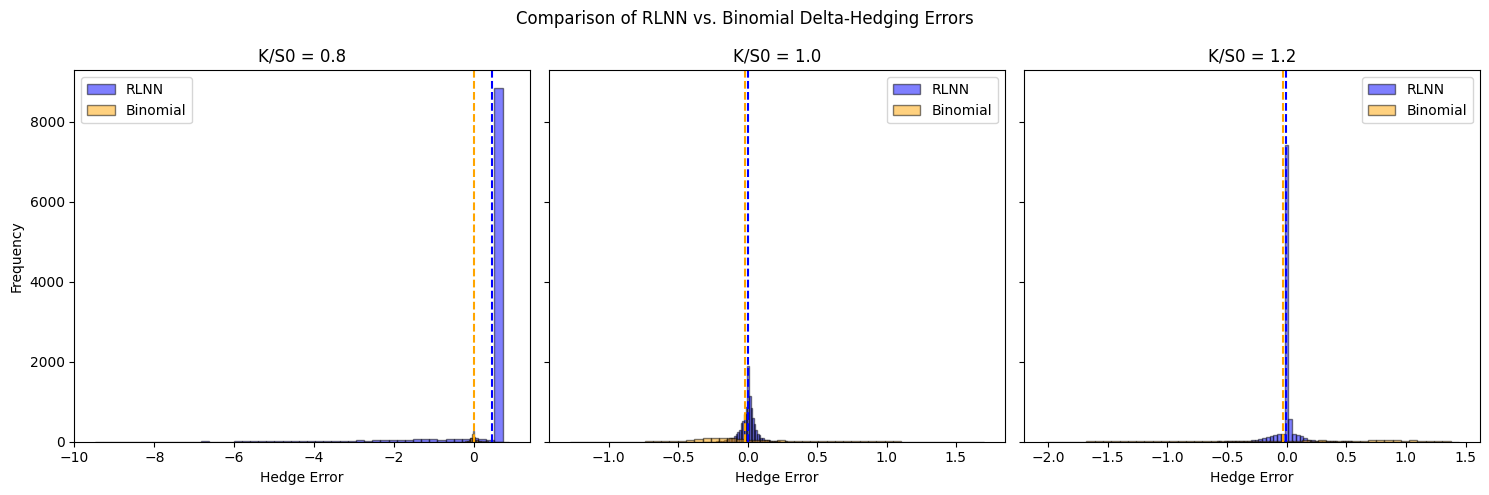

In [4]:
# parameters
S0 = 50
sigma = 0.2
r = 0.06
T = 1.0
M = 4            # number of monitoring dates for RLNN
N_RLNN = 1000   # number of paths for RLNN training
nodes = 16       # hidden layer size
style = 'put'    # put option
l_rate = 0.05

# Create 3 strike ratios
K_08 = 0.8 * S0
K_10 = 1.0 * S0
K_12 = 1.2 * S0

hedge_freq = 252
hedging_dates = np.linspace(0, T, hedge_freq + 1)
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])


# A) RLNN Price & Weights for each moneyness ratio

# def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate2):

price_08, weights_08, errors_08 = RLNN_Algo(S0, K_08, r, sigma,
                                            N_RLNN, M, T, style,
                                            nodes, l_rate)
price_10, weights_10, errors_10 = RLNN_Algo(S0, K_10, r, sigma,
                                            N_RLNN, M, T, style,
                                            nodes, l_rate)
price_12, weights_12, errors_12 = RLNN_Algo(S0, K_12, r, sigma,
                                            N_RLNN, M, T, style,
                                            nodes, l_rate)

print("RLNN Price (K=0.8*S0):", price_08)
print("RLNN Price (K=1.0*S0):", price_10)
print("RLNN Price (K=1.2*S0):", price_12)

# B) Generate out-of-sample paths for hedging


n_test = 1000  # number of OOS paths
test_paths_08 = stock_price_simulator(S0, r, sigma, T, M, n_test)
test_paths_10 = stock_price_simulator(S0, r, sigma, T, M, n_test)
test_paths_12 = stock_price_simulator(S0, r, sigma, T, M, n_test)

# C) RLNN Hedging Errors


hedge_error_rlnn_08 = hedging_simulation_proper_pnl(
    test_paths_08, weights_08, r, sigma, T, M, S0, K_08, price_08, nodes
)
hedge_error_rlnn_10 = hedging_simulation_proper_pnl(
    test_paths_10, weights_10, r, sigma, T, M, S0, K_10, price_10, nodes
)
hedge_error_rlnn_12 = hedging_simulation_proper_pnl(
    test_paths_12, weights_12, r, sigma, T, M, S0, K_12, price_12, nodes
)

# D) Binomial Delta Hedging Errors
steps_binom = 100

# def calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 10000, option_type='put'):
hedge_error_bin_08 = calculate_hedge_error(S0, K_08, r, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 1000, option_type='put')
hedge_error_bin_10 = calculate_hedge_error(S0, K_10, r, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 1000, option_type='put')
hedge_error_bin_12 = calculate_hedge_error(S0, K_12, r, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 1000, option_type='put')

# =========================================================================
# E) Print / Plot
# =========================================================================
print("RLNN mean hedge error (K=0.8):", np.mean(hedge_error_rlnn_08))
print("Binomial mean hedge error (K=0.8):", np.mean(hedge_error_bin_08))
print("RLNN mean hedge error (K=1.0):", np.mean(hedge_error_rlnn_10))
print("Binomial mean hedge error (K=1.0):", np.mean(hedge_error_bin_10))
print("RLNN mean hedge error (K=1.2):", np.mean(hedge_error_rlnn_12))
print("Binomial mean hedge error (K=1.2):", np.mean(hedge_error_bin_12))

# Example: subplots comparing RLNN vs. Binomial for each strike ratio
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# -- K=0.8*S0
axes[0].hist(hedge_error_rlnn_08, bins=50, alpha=0.5, color='blue',
                edgecolor='black', label='RLNN')
axes[0].hist(hedge_error_bin_08,  bins=50, alpha=0.5, color='orange',
                edgecolor='black', label='Binomial')
axes[0].axvline(x=hedge_error_rlnn_08.mean(), color='blue', linestyle='--')
axes[0].axvline(x=hedge_error_bin_08.mean(),  color='orange', linestyle='--')
axes[0].set_title("K/S0 = 0.8")
axes[0].legend()
axes[0].set_xlabel("Hedge Error")
axes[0].set_ylabel("Frequency")

# -- K=1.0*S0
axes[1].hist(hedge_error_rlnn_10, bins=50, alpha=0.5, color='blue',
                edgecolor='black', label='RLNN')
axes[1].hist(hedge_error_bin_10,  bins=50, alpha=0.5, color='orange',
                edgecolor='black', label='Binomial')
axes[1].axvline(x=hedge_error_rlnn_10.mean(), color='blue', linestyle='--')
axes[1].axvline(x=hedge_error_bin_10.mean(),  color='orange', linestyle='--')
axes[1].set_title("K/S0 = 1.0")
axes[1].legend()
axes[1].set_xlabel("Hedge Error")

# -- K=1.2*S0
axes[2].hist(hedge_error_rlnn_12, bins=50, alpha=0.5, color='blue',
                edgecolor='black', label='RLNN')
axes[2].hist(hedge_error_bin_12,  bins=50, alpha=0.5, color='orange',
                edgecolor='black', label='Binomial')
axes[2].axvline(x=hedge_error_rlnn_12.mean(), color='blue', linestyle='--')
axes[2].axvline(x=hedge_error_bin_12.mean(),  color='orange', linestyle='--')
axes[2].set_title("K/S0 = 1.2")
axes[2].legend()
axes[2].set_xlabel("Hedge Error")

plt.suptitle("Comparison of RLNN vs. Binomial Delta-Hedging Errors")
plt.tight_layout()
plt.show()

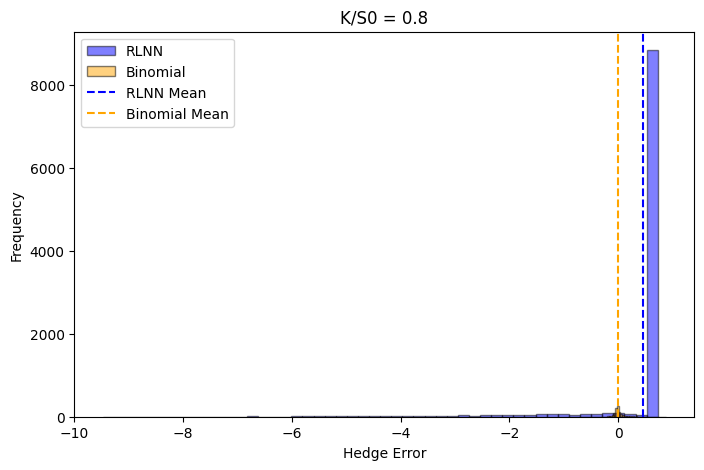

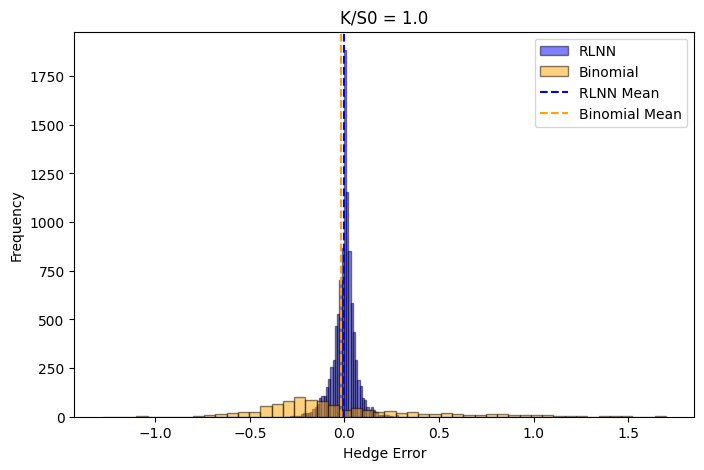

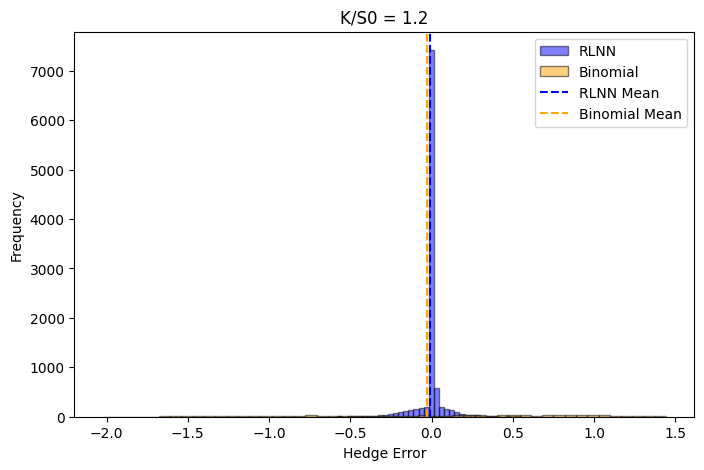

In [8]:
# Plot for K=0.8*S0
plt.figure(figsize=(8, 5))
plt.hist(hedge_error_rlnn_08, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
plt.hist(hedge_error_bin_08, bins=50, alpha=0.5, color='orange', edgecolor='black', label='Binomial')
plt.axvline(x=hedge_error_rlnn_08.mean(), color='blue', linestyle='--', label='RLNN Mean')
plt.axvline(x=hedge_error_bin_08.mean(), color='orange', linestyle='--', label='Binomial Mean')
plt.title("K/S0 = 0.8")
plt.legend()
plt.xlabel("Hedge Error")
plt.ylabel("Frequency")
plt.show()

# Plot for K=1.0*S0
plt.figure(figsize=(8, 5))
plt.hist(hedge_error_rlnn_10, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
plt.hist(hedge_error_bin_10, bins=50, alpha=0.5, color='orange', edgecolor='black', label='Binomial')
plt.axvline(x=hedge_error_rlnn_10.mean(), color='blue', linestyle='--', label='RLNN Mean')
plt.axvline(x=hedge_error_bin_10.mean(), color='orange', linestyle='--', label='Binomial Mean')
plt.title("K/S0 = 1.0")
plt.legend()
plt.xlabel("Hedge Error")
plt.ylabel("Frequency")
plt.show()

# Plot for K=1.2*S0
plt.figure(figsize=(8, 5))
plt.hist(hedge_error_rlnn_12, bins=50, alpha=0.5, color='blue', edgecolor='black', label='RLNN')
plt.hist(hedge_error_bin_12, bins=50, alpha=0.5, color='orange', edgecolor='black', label='Binomial')
plt.axvline(x=hedge_error_rlnn_12.mean(), color='blue', linestyle='--', label='RLNN Mean')
plt.axvline(x=hedge_error_bin_12.mean(), color='orange', linestyle='--', label='Binomial Mean')
plt.title("K/S0 = 1.2")
plt.legend()
plt.xlabel("Hedge Error")
plt.ylabel("Frequency")
plt.show()